In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt
import seaborn as sns

from numba import cuda

In [2]:
pd.__version__

'0.24.2'

# Import data

In [46]:
data = pd.read_csv('SP-280-Leste.csv', sep=',',header=None)
data.head()

,0,1,2,3
0,1,01/09/2011 00:00,37,89.0
1,2,01/09/2011 00:05,48,82.0
2,3,01/09/2011 00:10,26,85.0
3,4,01/09/2011 00:15,47,81.0
4,5,01/09/2011 00:20,52,82.0


## Clean and organize dataset

### Organize the dataset

Organize the columns, remove some not useful data, rename the columns and convert each column to your correct unit.

### Date-time columns

Working with date-time date requires to change the index DataFrame to the column that contain Date-Time values


In [47]:
'''Organize'''
# Drop the column '0'
data = data.drop(columns=0)

# Rename columns
data = data.rename(columns={0:"ID", 1:"Data-Hora",2:"Fluxo[veic/h.faixa]", 3:"Velocidade[km/h]" })

# Calculate flow rate
data["Fluxo[veic/h.faixa]"] = data["Fluxo[veic/h.faixa]"] * 60 / 5 / 2 # two lanes

# Calculate Density
data["Densidade[veic/km.faixa]"] = data["Fluxo[veic/h.faixa]"] / data['Velocidade[km/h]']

# Convert to_datetime
data['Data-Hora'] = pd.to_datetime(data['Data-Hora'], format='%d/%m/%Y %H:%M')

'''Date-time column index'''
data.set_index('Data-Hora',inplace=True)
data.head()

,Fluxo[veic/h.faixa],Velocidade[km/h],Densidade[veic/km.faixa]
Data-Hora,,,
2011-09-01 00:00:00,222.0,89.0,2.494382
2011-09-01 00:05:00,288.0,82.0,3.512195
2011-09-01 00:10:00,156.0,85.0,1.835294
2011-09-01 00:15:00,282.0,81.0,3.481481
2011-09-01 00:20:00,312.0,82.0,3.804878


In [48]:
print(data.dtypes)
print(data.shape)

Fluxo[veic/h.faixa]         float64
Velocidade[km/h]            float64
Densidade[veic/km.faixa]    float64
dtype: object
(105408, 3)


### Missing values

Verifying some missing values in dataset

In [49]:
data[data.isna()['Velocidade[km/h]']]

,Fluxo[veic/h.faixa],Velocidade[km/h],Densidade[veic/km.faixa]
Data-Hora,,,
2011-10-16 00:45:00,0.0,NaN,NaN


In [50]:
data.isna().sum()

Fluxo[veic/h.faixa]          0
Velocidade[km/h]             1
Densidade[veic/km.faixa]    39
dtype: int64

In [51]:
data = data.fillna(0.0)
data.isna().sum()

Fluxo[veic/h.faixa]         0
Velocidade[km/h]            0
Densidade[veic/km.faixa]    0
dtype: int64

## Understand Date-Time Index

Using this index with diferents date-time provide some useful grouping functions

In [52]:
# Select data from year 2011, month October, day 2, and 12 a.m.
data['2011-10-02 12']

,Fluxo[veic/h.faixa],Velocidade[km/h],Densidade[veic/km.faixa]
Data-Hora,,,
2011-10-02 12:00:00,1092.0,102.0,10.705882
2011-10-02 12:05:00,990.0,99.0,10.000000
2011-10-02 12:10:00,864.0,102.0,8.470588
2011-10-02 12:15:00,972.0,99.0,9.818182
2011-10-02 12:20:00,1092.0,98.0,11.142857
2011-10-02 12:25:00,990.0,99.0,10.000000
2011-10-02 12:30:00,1122.0,100.0,11.220000
2011-10-02 12:35:00,1068.0,100.0,10.680000
2011-10-02 12:40:00,1014.0,102.0,9.941176


Resampling the dataset grouped by each day

In [53]:
resampled = data.resample('M')
for name, group in resampled:
    print('Group: ', name)
    print('-' * 27)
    print(group,end='\n\n')

Group:  2011-09-30 00:00:00
---------------------------
                     Fluxo[veic/h.faixa]  Velocidade[km/h]  \
Data-Hora                                                    
2011-09-01 00:00:00                222.0              89.0   
2011-09-01 00:05:00                288.0              82.0   
2011-09-01 00:10:00                156.0              85.0   
2011-09-01 00:15:00                282.0              81.0   
2011-09-01 00:20:00                312.0              82.0   
2011-09-01 00:25:00                222.0              90.0   
2011-09-01 00:30:00                126.0              84.0   
2011-09-01 00:35:00                198.0              84.0   
2011-09-01 00:40:00                108.0              73.0   
2011-09-01 00:45:00                156.0              85.0   
2011-09-01 00:50:00                174.0              87.0   
2011-09-01 00:55:00                180.0              83.0   
2011-09-01 01:00:00                102.0              75.0   
2011-09-01 01:

In [11]:
resampled.groups

{Timestamp('2011-09-30 00:00:00', freq='M'): 8640,
 Timestamp('2011-10-31 00:00:00', freq='M'): 17568,
 Timestamp('2011-11-30 00:00:00', freq='M'): 26208,
 Timestamp('2011-12-31 00:00:00', freq='M'): 35136,
 Timestamp('2012-01-31 00:00:00', freq='M'): 44064,
 Timestamp('2012-02-29 00:00:00', freq='M'): 52416,
 Timestamp('2012-03-31 00:00:00', freq='M'): 61344,
 Timestamp('2012-04-30 00:00:00', freq='M'): 69984,
 Timestamp('2012-05-31 00:00:00', freq='M'): 78912,
 Timestamp('2012-06-30 00:00:00', freq='M'): 87552,
 Timestamp('2012-07-31 00:00:00', freq='M'): 96480,
 Timestamp('2012-08-31 00:00:00', freq='M'): 105408}

In [41]:
def plotBoxContinous(data, savefig=False, filename='test.png'):
    arrVel = np.array(data)
    arrVel = arrVel.reshape(288,366)
    plt.figure(figsize=(20,10))
    plt.boxplot(arrVel)
    if(savefig):
        plt.savefig(filename, dpi=600)
    plt.show()

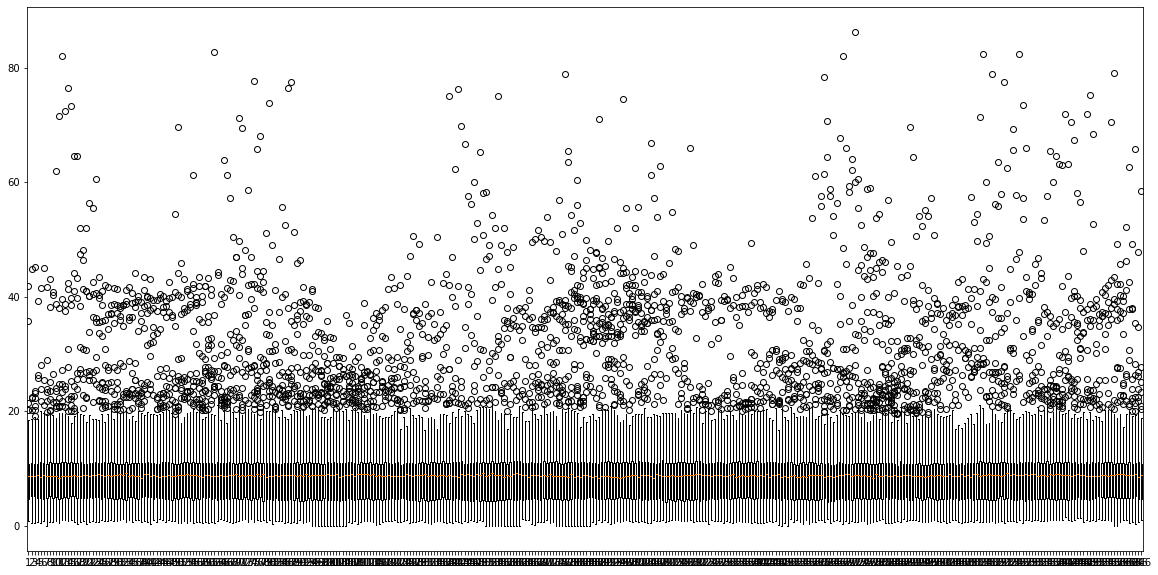

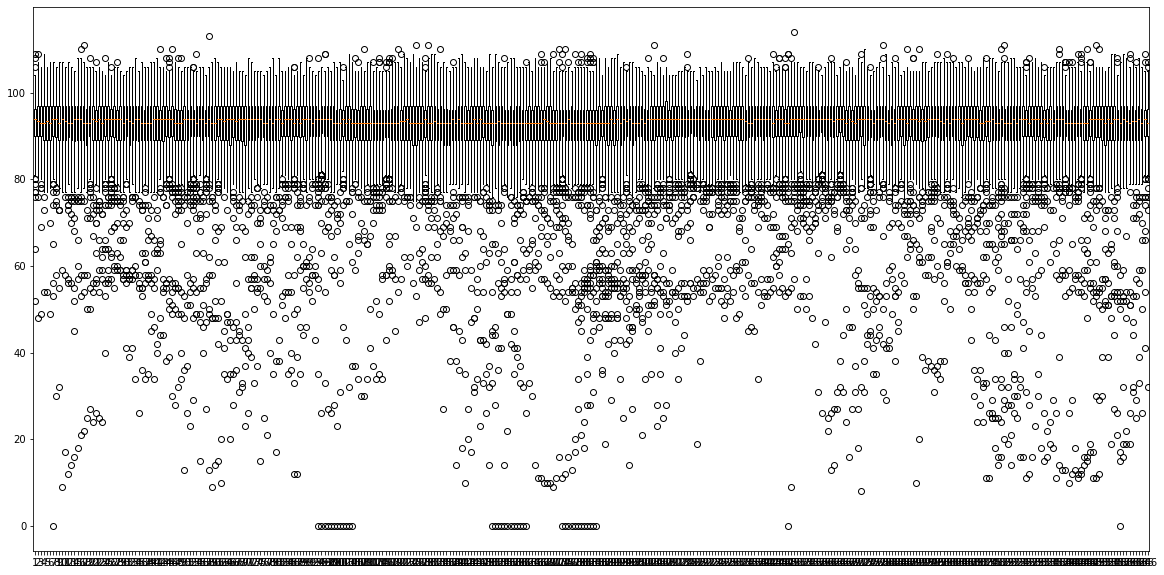

In [42]:
plotBoxContinous(data['Densidade[veic/km.faixa]'], savefig=True, filename='Density_boxplot_Daily.png')

plotBoxContinous(data['Velocidade[km/h]'])

# Plotting data

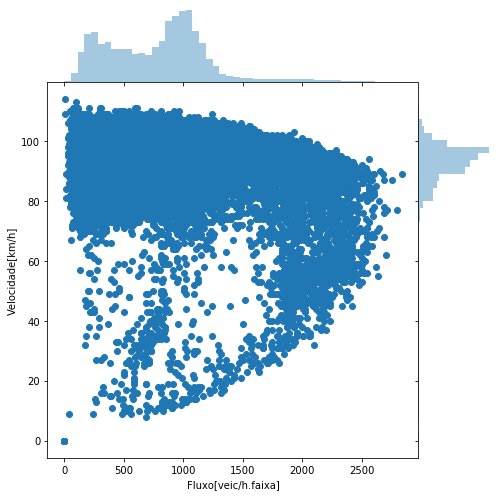

In [44]:
#sns.set(style='white')
g = sns.jointplot(data['Fluxo[veic/h.faixa]'], data['Velocidade[km/h]'], kind='scatter', height=7, space=0)

### Using Matplotlib

C:\Users\alcunha\AppData\Local\Continuum\miniconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


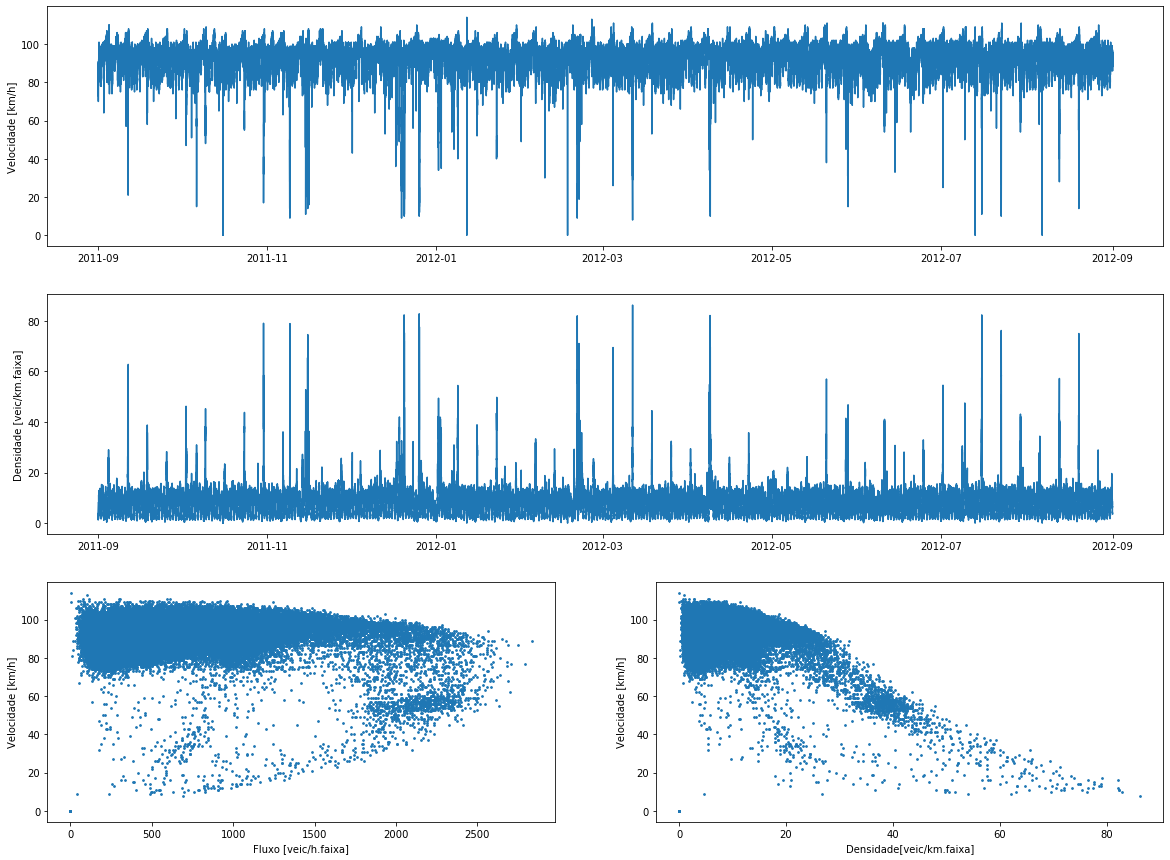

In [15]:
plt.figure(figsize=(20,15))

ax1 = plt.subplot(3,2,(1,2))
plt.plot(data['Velocidade[km/h]'])
ax1.set(ylabel = 'Velocidade [km/h]')

ax2=plt.subplot(3,2,(3,4))
plt.plot(data['Densidade[veic/km.faixa]'])
ax2.set(ylabel = 'Densidade [veic/km.faixa]')

ax3 = plt.subplot(3,2,5)
plt.scatter(data['Fluxo[veic/h.faixa]'], data['Velocidade[km/h]'], s=3)
ax3.set(xlabel='Fluxo [veic/h.faixa]', ylabel = 'Velocidade [km/h]')

ax4 = plt.subplot(3,2,6)
plt.scatter(data['Densidade[veic/km.faixa]'], data['Velocidade[km/h]'], s=3 )
ax4.set(xlabel='Densidade[veic/km.faixa]', ylabel='Velocidade [km/h]')

plt.show()

### Using Pandas

In [54]:
data.corr()

,Fluxo[veic/h.faixa],Velocidade[km/h],Densidade[veic/km.faixa]
Fluxo[veic/h.faixa],1.000000,0.069051,0.888302
Velocidade[km/h],0.069051,1.000000,-0.278193
Densidade[veic/km.faixa],0.888302,-0.278193,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000188576E39E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000188601BBC50>]], dtype=object)

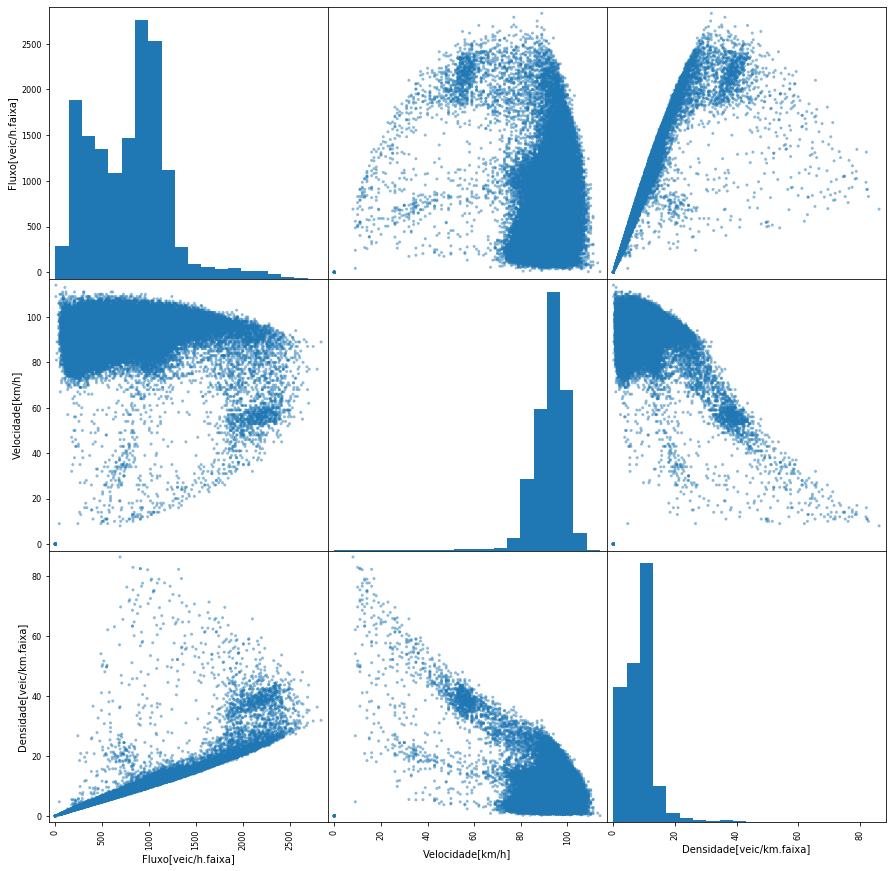

In [57]:
pd.plotting.scatter_matrix(data, figsize=(15,15), diagonal='hist', hist_kwds={'bins':20})

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001885F89CD30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001885D6935F8>], dtype=object)

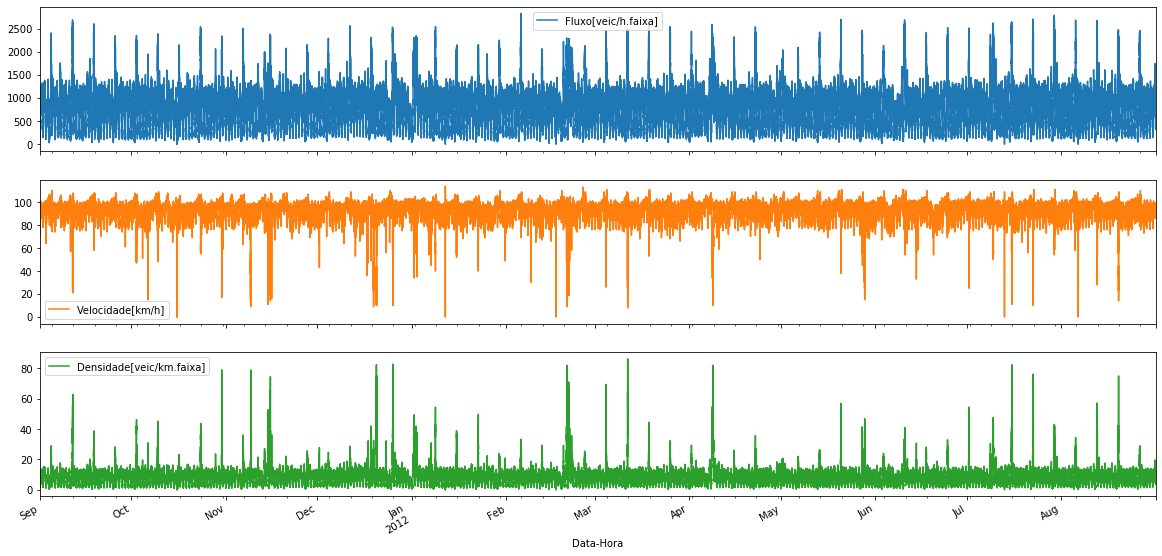

In [56]:
data.plot(subplots=True, figsize=(20,10))

### Others plotting tests

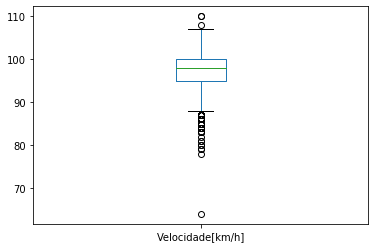

In [58]:
data['2011-09-03':'2011-09-04']['Velocidade[km/h]'].plot(kind='box')

Data-Hora
2011-09-30    AxesSubplot(0.125,0.125;0.775x0.755)
2011-10-31    AxesSubplot(0.125,0.125;0.775x0.755)
2011-11-30    AxesSubplot(0.125,0.125;0.775x0.755)
2011-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2012-01-31    AxesSubplot(0.125,0.125;0.775x0.755)
2012-02-29    AxesSubplot(0.125,0.125;0.775x0.755)
2012-03-31    AxesSubplot(0.125,0.125;0.775x0.755)
2012-04-30    AxesSubplot(0.125,0.125;0.775x0.755)
2012-05-31    AxesSubplot(0.125,0.125;0.775x0.755)
2012-06-30    AxesSubplot(0.125,0.125;0.775x0.755)
2012-07-31    AxesSubplot(0.125,0.125;0.775x0.755)
2012-08-31    AxesSubplot(0.125,0.125;0.775x0.755)
Freq: M, Name: Velocidade[km/h], dtype: object

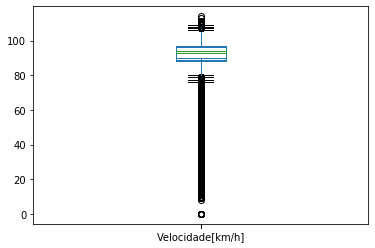

In [62]:
data['Velocidade[km/h]'].resample('M').plot(kind='box')

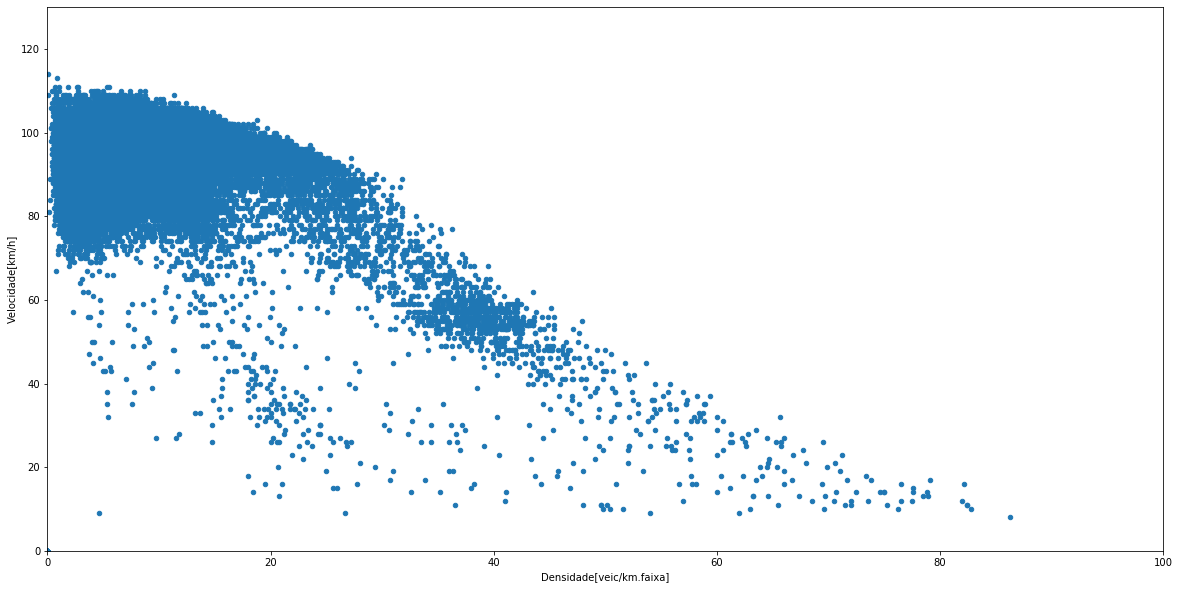

In [21]:
data.plot(x='Densidade[veic/km.faixa]',
          y='Velocidade[km/h]',
          kind='scatter',
          figsize=(20,10),
         xlim=(0,100),
         ylim=(0,130))

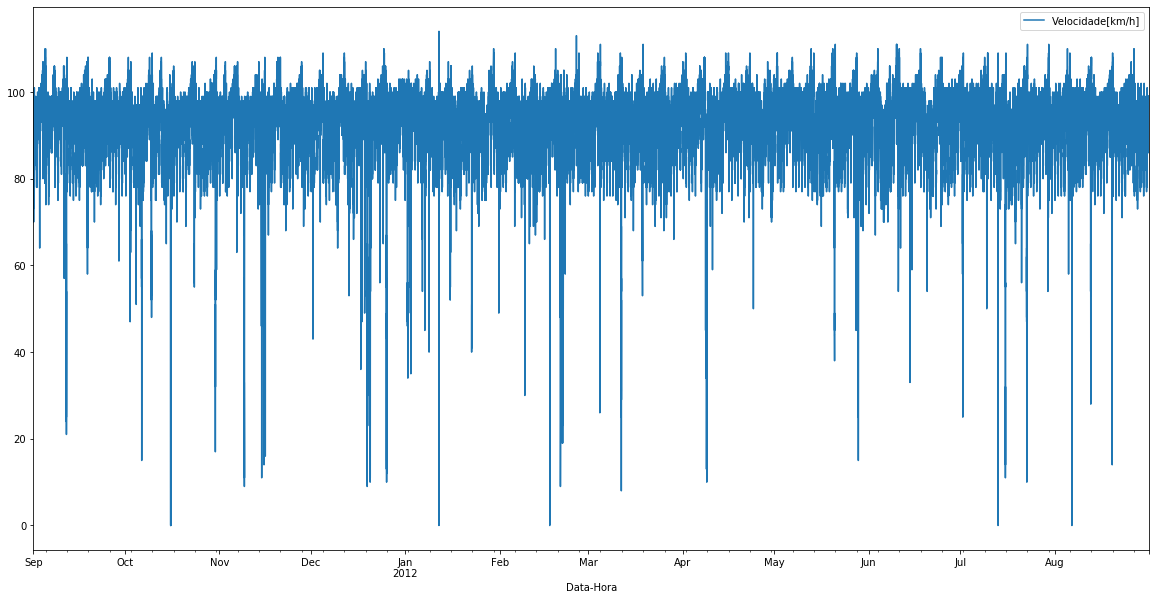

In [22]:
data.plot(y='Velocidade[km/h]',
          kind='line',
          figsize=(20,10))

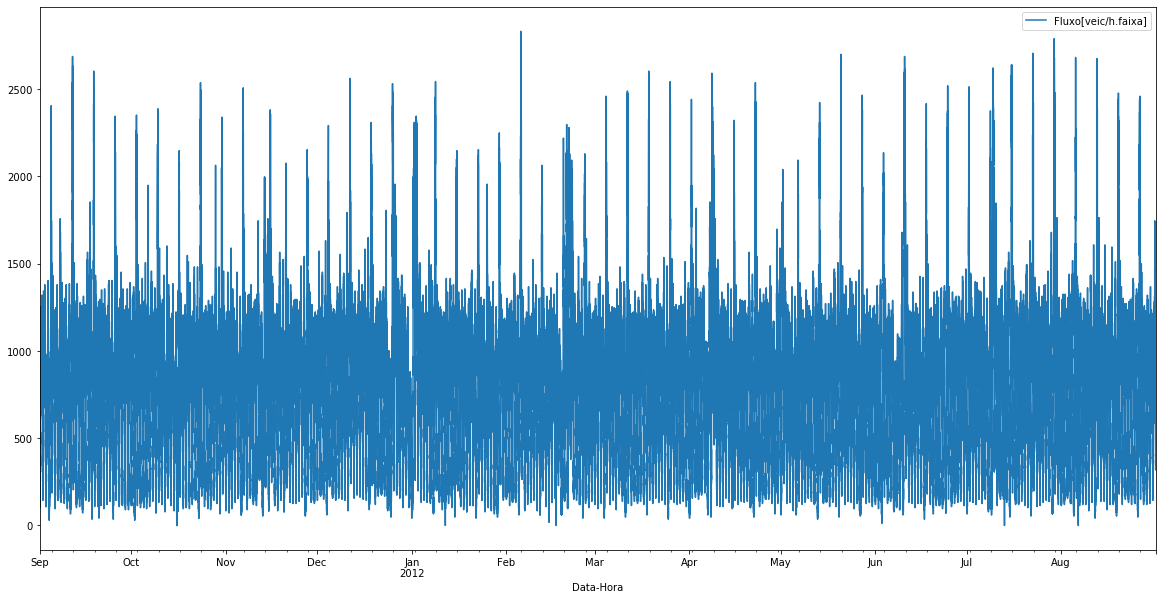

In [23]:
data.plot(y='Fluxo[veic/h.faixa]',
          kind='line',
          figsize=(20,10))

# Filtering Data Analysis

## Testing within 50% of data

### Filtering 'Speed' - ALL DATA

In [63]:
data.describe()

,Fluxo[veic/h.faixa],Velocidade[km/h],Densidade[veic/km.faixa]
count,105408.000000,105408.000000,105408.000000
mean,782.236566,92.168583,8.622564
std,416.745635,8.061075,5.570966
min,0.000000,0.000000,0.000000
25%,426.000000,89.000000,4.750000
50%,840.000000,94.000000,8.848485
75%,1038.000000,97.000000,11.032258
max,2832.000000,114.000000,86.250000


60741
102792


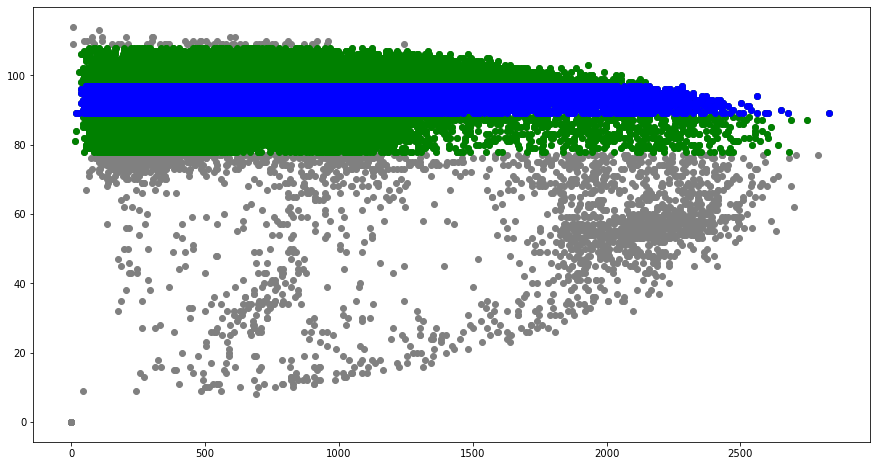

In [64]:
# Determine mask of Speed values with 50% of all data
mask50 = (data['Velocidade[km/h]'] >= data.quantile(.25)['Velocidade[km/h]']) & (data['Velocidade[km/h]'] <= data.quantile(.75)['Velocidade[km/h]'])
print(mask50.sum())

# Determine the whiskers (1.5 * IQR)
IQR = data.quantile(.75)['Velocidade[km/h]'] - data.quantile(.25)['Velocidade[km/h]']
maskIQR = ((data['Velocidade[km/h]'] > data.quantile(.25)['Velocidade[km/h]'] - 1.5 * IQR) & 
(data['Velocidade[km/h]'] < data.quantile(.75)['Velocidade[km/h]'] + 1.5 * IQR ) )
print(maskIQR.sum())

var = 'Fluxo[veic/h.faixa]'
#var = 'Densidade[veic/km.faixa]'

plt.figure(figsize = (15,8))
plt.scatter(data[var], data['Velocidade[km/h]'], color='grey') 
plt.scatter(data[maskIQR][var], data[maskIQR]['Velocidade[km/h]'], color='green')
plt.scatter(data[mask50][var], data[mask50]['Velocidade[km/h]'], color='blue')

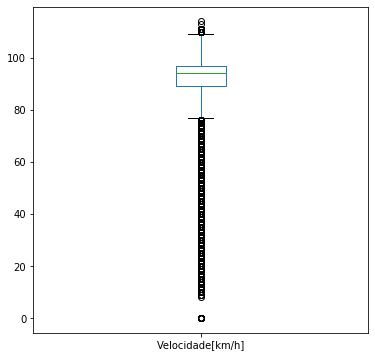

In [65]:
data['Velocidade[km/h]'].plot(kind='box', figsize=(6,6))

### Filtering 'Speed' - FOR EACH SPECIFIC PERIOD

In [66]:
# function to check specified quantile:
def in_qrange(ser, q):
    return ser.between(*ser.quantile(q=q))

def in_IQRrange(ser, dev=1.5):
    p25, p75 = ser.quantile([.25, .75])
    IQR = p75-p25
    return ser.between( p25 - dev * IQR, p75 + dev * IQR, inclusive = False)

59347
101016


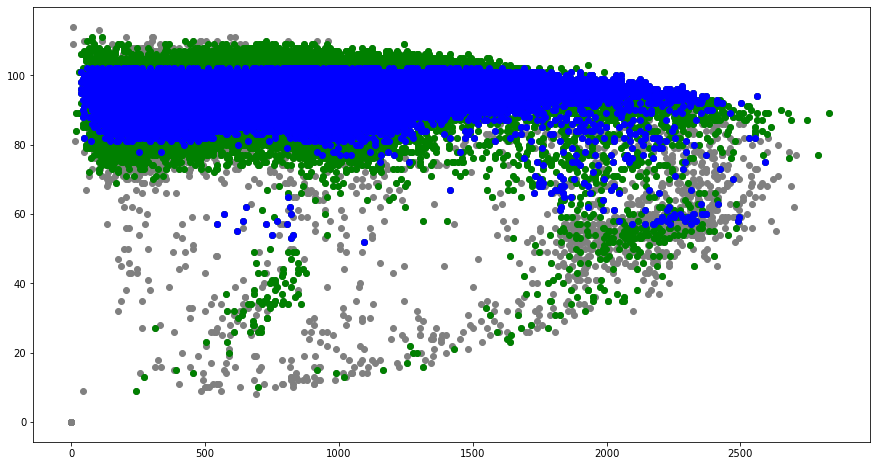

In [67]:
period = 'D'

# Determine mask of Speed values with 50% of each month
mask50 = data.resample(period)['Velocidade[km/h]'].transform(in_qrange, q=[.25, .75])
print(mask50.sum())

# Determine the whiskers (1.5 * IQR)
maskIQR = data.resample(period)['Velocidade[km/h]'].transform(in_IQRrange, dev=1.5)
print(maskIQR.sum())

var = 'Fluxo[veic/h.faixa]'
#var = 'Densidade[veic/km.faixa]'

plt.figure(figsize = (15,8))
plt.scatter(data[var], data['Velocidade[km/h]'], color='grey' ) 
plt.scatter(data[maskIQR][var], data[maskIQR]['Velocidade[km/h]'], color='green')
plt.scatter(data[mask50][var], data[mask50]['Velocidade[km/h]'], color='blue')

In [104]:
#data.groupby(by=pd.Grouper(freq='M')).plot(y='Velocidade[km/h]',kind='box')
def plotBoxPlotFreq(df, freq='W', var='Velocidade[km/h]'):
    dt = df.copy()
    dt['status'] = 0
    g = dt.resample(freq)
    idx = 0
    for v in g.indices.values():
        idx += 1
        dt['status'][v[0]:v[-1]] = idx

    mask = dt['status'] > 0
    dt[mask].boxplot(column=var, by='status', figsize=(20,6))

C:\Users\alcunha\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


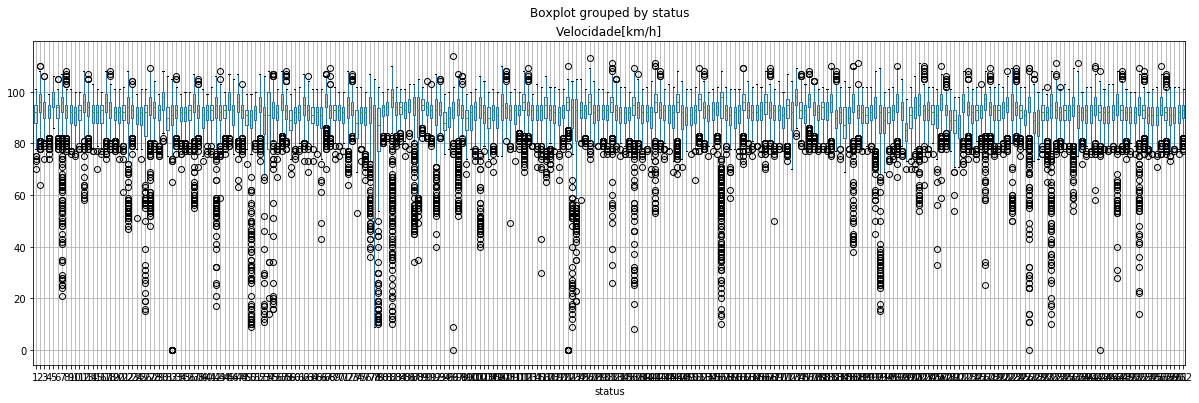

In [107]:
plotBoxPlotFreq(data, freq='B')

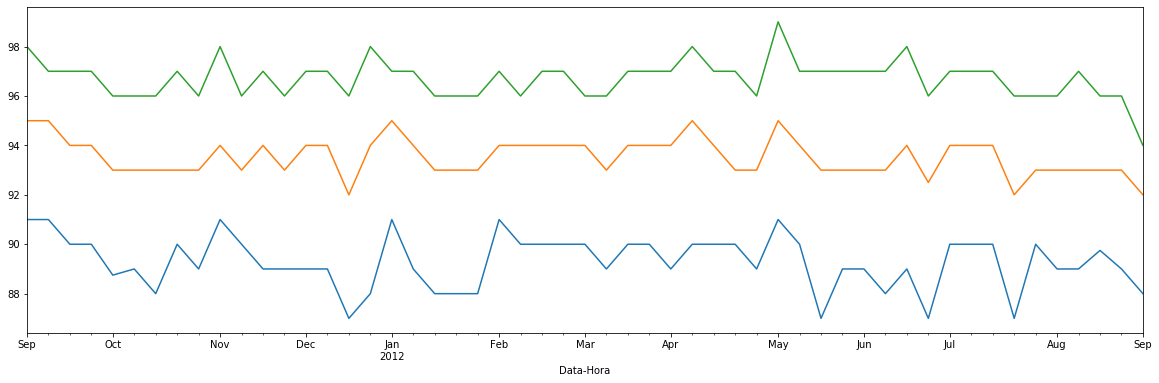

In [105]:
data['Velocidade[km/h]'].resample(period).quantile(.25).plot(figsize=(20,6))
data['Velocidade[km/h]'].resample(period).quantile(.5).plot()
#data['Velocidade[km/h]'].resample(period).mean().plot(marker='o')
data['Velocidade[km/h]'].resample(period).quantile(.75).plot()

# Wavelet Analysis

## Introduction

In [31]:
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [32]:
t = 5#min
n = 288#data.size

while n>2:
    print(t,' min -> ', n)
    t *= 2
    n /= 2

5  min ->  288
10  min ->  144.0
20  min ->  72.0
40  min ->  36.0
80  min ->  18.0
160  min ->  9.0
320  min ->  4.5
640  min ->  2.25


## Applying in all dataset

In [33]:
cA, cD = pywt.dwt(data['Densidade[veic/km.faixa]'],'haar')

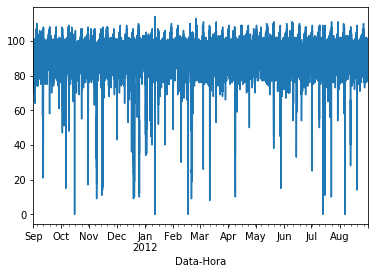

In [34]:
data['Velocidade[km/h]'].plot()

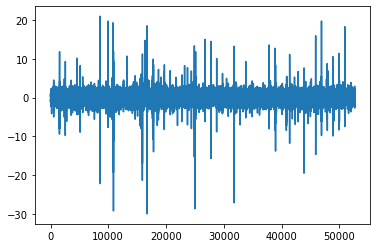

In [35]:
plt.plot(cD)

In [36]:
nlevel = 8
res = pywt.wavedec(data['Velocidade[km/h]'],'haar',level=nlevel)
#res

Mean =  1474.7189017  | Std =  54.6979215969
Mean =  -1.57296723301  | Std =  45.1972949026
Mean =  -0.774577983457  | Std =  38.032904051
Mean =  -0.0578324225865  | Std =  28.4511568726
Mean =  -0.0942379711417  | Std =  15.9762424337
Mean =  0.0622343655131  | Std =  7.83338162127
Mean =  0.00708394771681  | Std =  4.829487343
Mean =  -0.0099043715847  | Std =  3.268703566
Mean =  -0.0327364250549  | Std =  2.80558548781


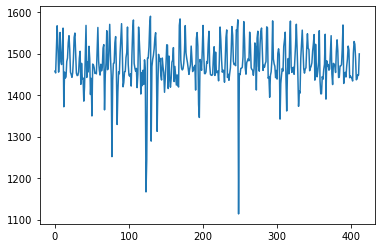

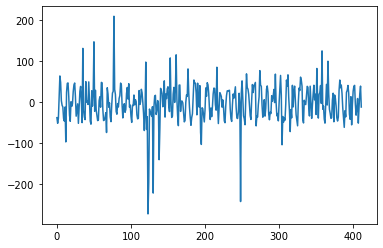

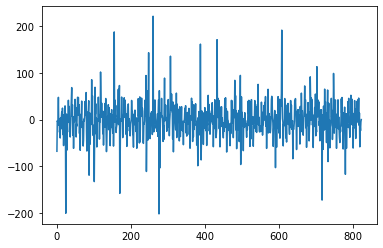

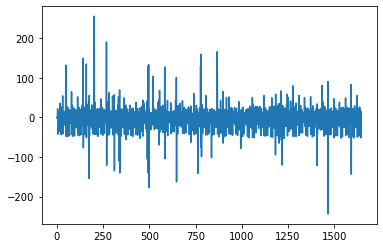

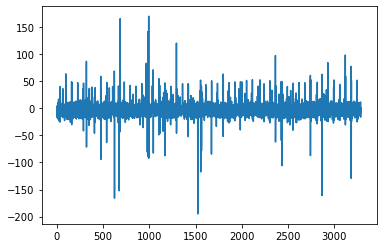

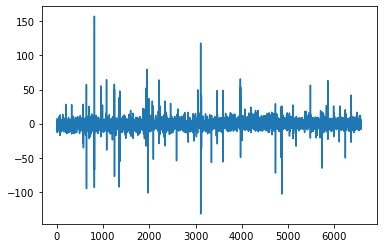

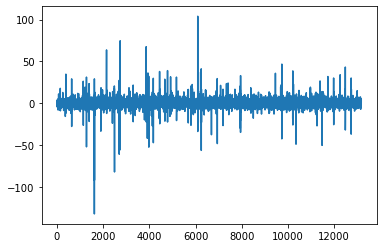

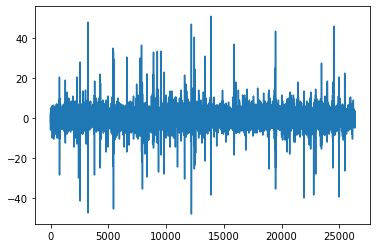

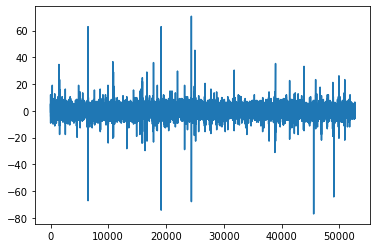

In [37]:
for i in range(nlevel+1):
    plt.figure()
    plt.plot(res[i])
    print('Mean = ', res[i].mean(),' | Std = ', res[i].std())

In [38]:
#level = 0
for level in range(nlevel+1):
    highvalue = res[level].mean() + 1.5 * res[level].std()
    lowvalue = res[level].mean() - 1.5 * res[level].std()

    res[level] = pywt.threshold(res[level], lowvalue, 'greater', lowvalue)
    res[level] = pywt.threshold(res[level], highvalue, 'less', highvalue)

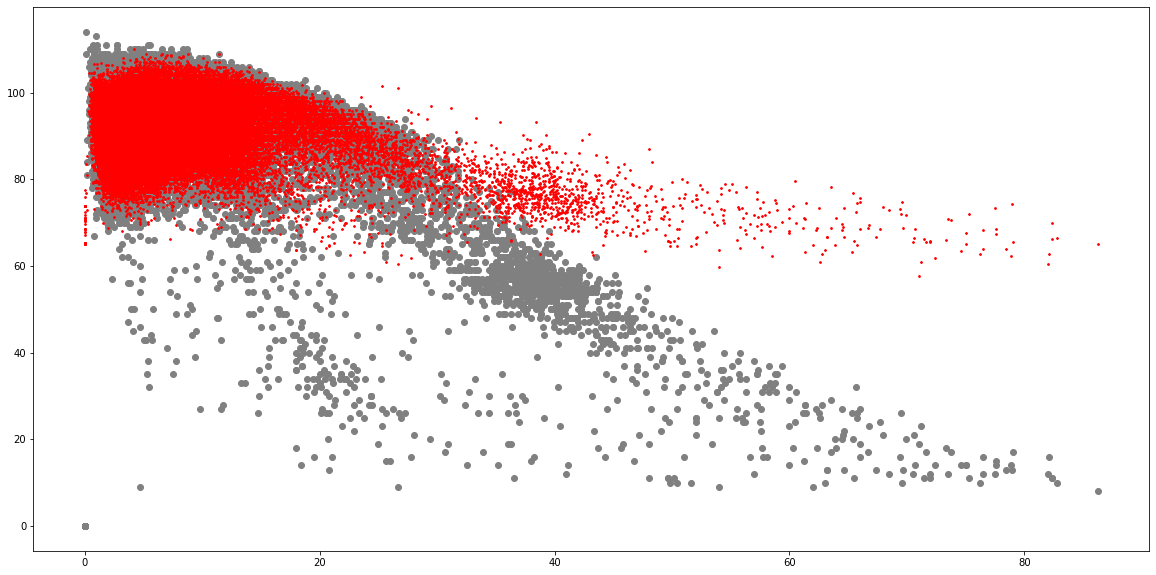

In [39]:
signal = pywt.waverec(res,'haar')

plt.figure(figsize = (20,10))
plt.scatter(data['Densidade[veic/km.faixa]'], data['Velocidade[km/h]'], color='grey')
plt.scatter(data['Densidade[veic/km.faixa]'], signal, s=3, color='red')

## Applying in each day

In [40]:
db = data[0:288]

# Plot Speed-Time and Flow-Time
fig = plt.figure()
plt.plot(db["Data-Hora"],db['Fluxo[veic/h.faixa]'])

fig = plt.figure()
plt.plot(db["Data-Hora"],db['Velocidade[km/h]'])

KeyError: 'Data-Hora'

<Figure size 432x288 with 0 Axes>

In [ ]:
cA, cD = pywt.dwt(db['Fluxo[veic/h.faixa]'] ,'haar')
plt.plot(cA)
plt.figure()
plt.plot(cD,color='orange')

In [ ]:
cA, cD = pywt.dwt(db['Velocidade[km/h]'] ,'haar')
plt.plot(cA)
plt.figure()
plt.plot(cD,color='orange')

In [ ]:
def scatterHist(x,y):
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    ax_scatter.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 20
    limx = np.ceil(np.abs(x).max() / binwidth) * binwidth
    limy = np.ceil(np.abs(y).max() / binwidth) * binwidth
    ax_scatter.set_xlim((0, limx))
    ax_scatter.set_ylim((0, limy))

    binsx = np.arange(0, limx + binwidth, binwidth)
    binsy = np.arange(0, limy + binwidth, binwidth)
    ax_histx.hist(x, bins=binsx)
    ax_histy.hist(y, bins=binsy, orientation='horizontal')

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())

    plt.show()

In [ ]:
scatterHist(data['Fluxo[veic/h.faixa]'], data['Velocidade[km/h]'])